In [1]:
import pickle
import os
import numpy as np

path = "/home/user/Datasets/interpolated/preprocess_results_10s_interp03scale9/test"
name = "0_80100_90100_24P0.pkl"
filepath = os.path.join(path, name)
f = open(filepath, 'rb')
data = pickle.load(f, encoding="latin1")

In [2]:
data.keys()

dict_keys(['shapes', 'idx', 'has_preds', 'gt_preds', 'steps', 'graph', 'trajs', 'ctrs', 'theta', 'rot', 'feats', 'orig'])

In [3]:
print(data['graph'].keys())
print(data['graph']['feats'])
print(data['graph']['left_pairs'])


dict_keys(['pre', 'lane_idcs', 'left_pairs', 'suc', 'road_polygon', 'num_nodes', 'pre_pairs', 'ctrs', 'suc_pairs', 'right_pairs', 'feats'])
[[ 2.8366485e-01 -2.7467957e-04]
 [ 2.8366485e-01 -2.7467957e-04]
 [ 2.8366485e-01 -2.7467957e-04]
 ...
 [ 1.0923077e-02  2.8543097e-01]
 [ 1.0923077e-02  2.8543097e-01]
 [ 1.0923077e-02  2.8543097e-01]]
[[1, 2], [19, 21], [22, 30], [32, 14], [33, 13], [35, 12], [42, 38], [43, 39], [44, 17], [45, 40]]


In [8]:
mp.shape

(3160, 2)

v size: (3165,)
0 l: 1
v size: (3170,)
1 l: 1
v size: (3180,)
2 l: 1
v size: (3200,)
3 l: 1
v size: (3240,)
4 l: 1
v size: (3320,)
5 l: 1
v size: (3315,)
6 l: 1
v size: (2980,)
v size: (1782,)
[3.8542423, 4.137907, 4.4258285, 5.267737, 7.42049, 10.974338, 13.142014] [-0.29720148, -0.29747617, -0.2979109, -0.17021348, 0.515598, 1.8148816, 8.866132]


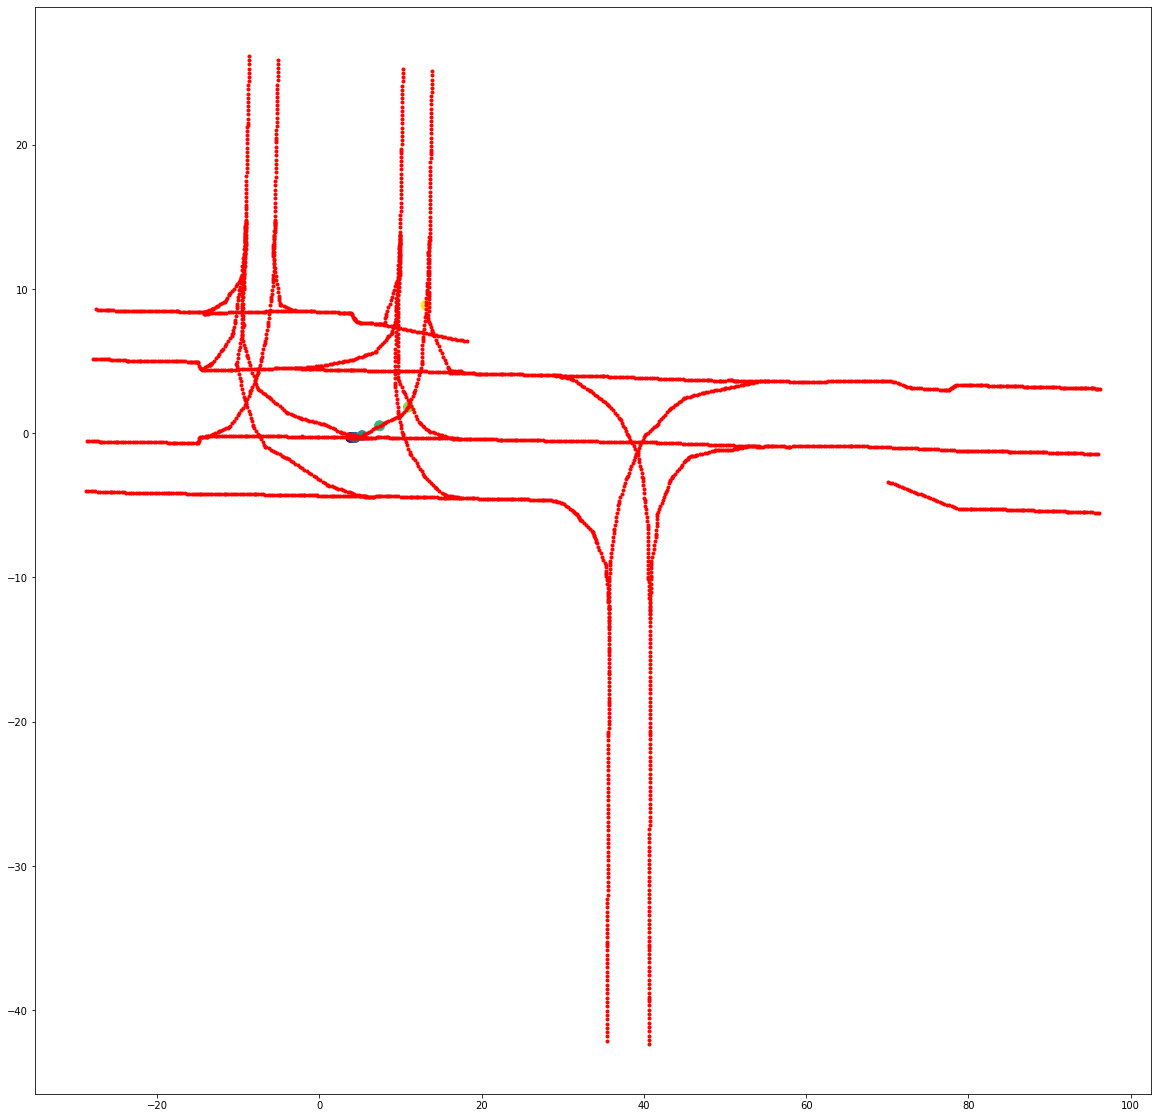

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=[20,20])
pt = 0
graph = data['graph']
mp = graph['ctrs']

X = []
Y = []
C = []

# cl = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

for i in range(len(graph['suc'])):
    u = graph['suc'][i]['u']
    v = graph['suc'][i]['v']
    print('v size:', v.shape)
    
    tmp = np.where(u == pt)
    if tmp is not None and tmp[0] is not None and tmp[0].shape[0] > 0:
        print(i, 'l:', len(tmp[0]))
        
        for idx in tmp[0]:
#             idx = tmp[0][0]

            X.append(mp[v[idx], 0])
            Y.append(mp[v[idx], 1])
            C.append(i)

            
# for side in ['left_pairs', 'right_pairs']:
#     u = graph[side]['u']
#     v = graph[side]['v']

#     tmp = np.where(u == pt)
#     if tmp and tmp[0] and tmp[0].shape[0] > 0:
#         print(side, 'l:', len(tmp[0]))
        
#         for idx in tmp[0]:
#             X.append(mp[v[idx], 0])
#             Y.append(mp[v[idx], 1])
#             C.append(1)
    
    
plt.plot(mp[:, 0], mp[:, 1], 'r.')
# plt.plot(X, Y)

plt.scatter(X, Y, s = 100, c = C)
print(X, Y)

# plt.savefig('/home/user/Logs/0607/地图6步未插值' + str(pt) + '.png')


In [ ]:
import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm
import sys
from importlib import import_module
from utils import Logger, load_pretrain, gpu, to_long,  Optimizer, StepLR

from data import InteDataset

root_path = '/home/user/Projects/LaneGCN_modified'
sys.path.insert(0, root_path)

model = import_module("lanegcn")
config, _, collate_fn, net, loss, post_process, opt = model.get_model(80)



ckpt_path = "/home/user/Projects/LaneGCN_modified/results/history_results/interpolated_map_results/lanegcn_10s/36.000.ckpt"
# ckpt_path = "/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt"

if not os.path.isabs(ckpt_path):
    ckpt_path = os.path.join(config["save_dir"], ckpt_path)
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()





dataset = InteDataset('/home/user/Datasets/interpolated/preprocess_results_10s/tmp/')
data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=True,
    pin_memory=True,
)

# begin inference
preds = {}
gts = {}
cities = {}

data_list = []
for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    with torch.no_grad():
        output = net(data)
        results = [x.detach().cpu().numpy() for x in output["reg"]]


In [ ]:
print(data['graph'][0].keys())
print(data['graph'][0]['feats'].shape)
print(data['graph'][0]['left_pairs'].shape)

In [ ]:
from lanegcn import graph_gather, actor_gather

actors, actor_idcs = actor_gather(gpu(data["feats"]))
actor_ctrs = gpu(data["ctrs"])
actors = net.actor_net(actors)

# construct map features
graph = graph_gather(to_long(gpu(data["graph"])))
nodes, node_idcs, node_ctrs = net.map_net(graph)

# actor-map fusion cycle 
nodes = net.a2m(nodes, graph, actors, actor_idcs, actor_ctrs)
nodes = net.m2m(nodes, graph)
actors = net.m2a(actors, actor_idcs, actor_ctrs, nodes, node_idcs, node_ctrs)
actors = net.a2a(actors, actor_idcs, actor_ctrs)

In [ ]:
print('len', len(node_ctrs))
print('node_ctrs[0]', node_ctrs[0].cpu().numpy().shape)
print(graph['pre'][0]['u'].cpu().numpy())

all_ctrs = torch.cat(node_ctrs, 0).cpu().numpy()
print(all_ctrs.shape)
idx = np.where(u == pt)
print(graph['left'])

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=[20,20])
pt = 270
mp = node_ctrs[0].cpu().numpy()

X = []
Y = []
C = []

cl = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

for i in range(len(graph['suc'])):
    u = graph['suc'][i]['u'].cpu().numpy()
    v = graph['suc'][i]['v'].cpu().numpy()
#     print('v size:', v.shape)
    
    tmp = np.where(u == pt)
    if tmp is not None and tmp[0] is not None and tmp[0].shape[0] > 0:
#         print(i, 'l:', len(tmp[0]))
        
        for idx in tmp[0]:
#             idx = tmp[0][0]

            X.append(all_ctrs[v[idx], 0])
            Y.append(all_ctrs[v[idx], 1])
            C.append(cl[i])

            
for side in ['left', 'right']:
    u = graph[side]['u'].cpu().numpy()
    v = graph[side]['v'].cpu().numpy()

    tmp = np.where(u == pt)
    if tmp and tmp[0] and tmp[0].shape[0] > 0:
        print(side, 'l:', len(tmp[0]))
        
        for idx in tmp[0]:
            X.append(all_ctrs[v[idx], 0])
            Y.append(all_ctrs[v[idx], 1])
            C.append(cl[1])
    
    
plt.plot(mp[:, 0], mp[:, 1], 'r.')
# plt.plot(X, Y)

plt.scatter(X, Y, s = 100, c = C)
print(X, Y)

# plt.savefig('/home/user/Logs/0607/地图6步未插值' + str(pt) + '.png')


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[20,20])

u = graph['pre'][i]['u'].cpu().numpy()
print('u size:', u.shape)
v = graph['pre'][i]['v'].cpu().numpy()